In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_recall_curve

In [2]:
def date_parser_func(date):
    return datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")

In [3]:
df_game_result = pd.read_csv("game_results.csv",parse_dates=["timestamp"],date_parser=date_parser_func)
df_users = pd.read_csv("users.csv",parse_dates=["create_time"],date_parser=date_parser_func)
df_predictions = pd.read_csv("predictions.csv")

In [4]:
df_game_result.shape

(812733, 9)

In [5]:
df_game_result.head()

,id,user_id,timestamp,winner,length,magic_used,player_cards,round,type
0,218714,218490,2019-11-10 01:14:52,1,375,7,52,1,1
1,219061,218490,2019-11-10 01:23:06,1,475,3,41,2,1
2,219430,218490,2019-11-10 01:31:24,1,476,0,13,3,1
3,219689,218490,2019-11-10 01:38:43,1,329,2,52,1,1
4,219859,218492,2019-11-10 01:42:48,1,297,2,52,1,1


In [6]:
df_users.head()

,id,create_time
0,218490,2019-11-10 00:57:10
1,218492,2019-11-10 01:32:13
2,218493,2019-11-10 01:43:16
3,218499,2019-11-10 03:26:18
4,218507,2019-11-10 07:02:37


In [7]:
df_game_result.dtypes

id                       int64
user_id                  int64
timestamp       datetime64[ns]
winner                   int64
length                   int64
magic_used               int64
player_cards             int64
round                    int64
type                     int64
dtype: object

In [8]:
df_users.dtypes

id                      int64
create_time    datetime64[ns]
dtype: object

Дата считалась правильно

Проверим данные на наличие пропущенных значений

In [9]:
df_game_result.isna().sum()

id              0
user_id         0
timestamp       0
winner          0
length          0
magic_used      0
player_cards    0
round           0
type            0
dtype: int64

In [10]:
df_users.isna().sum()

id             0
create_time    0
dtype: int64

Пропущенных значений нет

Соединим 2 набора данных

In [11]:
df_users.rename(columns={"id":"user_id"},inplace=True)

In [12]:
result_df = df_game_result.join(df_users.set_index("user_id"),on="user_id")

Как мне кажется, наиболее оптимальной будет модель использующая деревья, так как она обладает наибольшей интерпретируемостью, поэтому все сгенеренные данные не нужно будет масштабировать. Данный пункт было бы разумнее описать в части про обучение модели, но мне кажется здесь тоже уместно.

Создадим новый столбец данных: разницу между временем регистрации и временем игры в секундах

In [13]:
result_df['diff'] = (result_df.timestamp-result_df.create_time)

In [14]:
result_df['diff'] = result_df['diff'].apply(lambda x: x.seconds)

Посмотрим сколько игр сыграл каждый игрок

Text(0.5, 1.0, 'Плотность распределения количества игр')

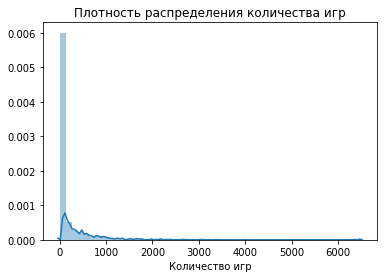

In [15]:
ax = sns.distplot(result_df.user_id.value_counts())
plt.xlabel("Количество игр")
plt.title("Плотность распределения количества игр")

Как видно из графика расперделения большинство игроков играют меньше 1000 игр, найдем это число. Найдем моду распределения.

In [16]:
result_df.user_id.value_counts().mode()

0    3
dtype: int64

Большинство игроков играют 3 игры.

Рассмотрим эти данные детальнее

In [17]:
result_df.user_id.value_counts().describe()

count    5289.000000
mean      153.664776
std       388.296857
min         1.000000
25%         3.000000
50%        12.000000
75%        95.000000
max      6479.000000
Name: user_id, dtype: float64

75 процентов игроков сыграли 95 или менее игр

In [19]:
result_df['count_of_games']=0

,id,user_id,timestamp,winner,length,magic_used,player_cards,round,type,create_time,diff,count_of_games
0,218714,218490,2019-11-10 01:14:52,1,375,7,52,1,1,2019-11-10 00:57:10,1062.0,0
1,219061,218490,2019-11-10 01:23:06,1,475,3,41,2,1,2019-11-10 00:57:10,1556.0,0
2,219430,218490,2019-11-10 01:31:24,1,476,0,13,3,1,2019-11-10 00:57:10,2054.0,0
3,219689,218490,2019-11-10 01:38:43,1,329,2,52,1,1,2019-11-10 00:57:10,2493.0,0
4,219859,218492,2019-11-10 01:42:48,1,297,2,52,1,1,2019-11-10 01:32:13,635.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
812728,19207349,234692,2020-05-09 11:35:10,0,254,0,9,1,1,2020-04-09 12:50:51,81859.0,0
812729,19208623,234692,2020-05-09 11:50:55,0,45,0,0,1,1,2020-04-09 12:50:51,82804.0,0
812730,19212265,234692,2020-05-09 12:32:59,1,701,0,16,1,1,2020-04-09 12:50:51,85328.0,0
812731,19212509,234692,2020-05-09 12:36:07,1,156,0,52,2,1,2020-04-09 12:50:51,85516.0,0


Функция для подсчета сыграных игр

In [22]:
def count_of_games(pd_arr):
    prev_index = -1
    for index in range(len(pd_arr)):
        if pd_arr.iloc[index]['user_id'] == pd_arr.iloc[prev_index]['user_id']:
            pd_arr.iloc[index,pd_arr.columns.get_loc('count_of_games')] = pd_arr.iloc[prev_index]['count_of_games']+1
        prev_index = index
        if index%100000==0:
            print(index)
     

Отсортируем всех игроков по user_id и времени игры, для того, чтобы правильно посчитать количетсво сыграных игр на текущий момент

In [23]:
result_df.sort_values(['user_id','timestamp'],inplace=True)

СЛЕДУЮЩАЯ ЧАСТЬ ООЧЕНЬ ДОЛГО СЧИТАЕТСЯ

In [ ]:
count_of_games(result_df)

In [27]:
result_df.drop(['timestamp'],axis=1,inplace=True)

Вычислим день недели, возможно по выходным люди чаще становятся космонавтами

In [21]:
result_df = pd.read_csv("user_features.csv")
result_df['create_time'] = pd.to_datetime(result_df['create_time'], format="%Y-%m-%d %H:%M:%S")

In [24]:
result_df['weekend'] = 0

In [25]:
def find_weekend(line):
    if (line['create_time'].weekday()>4):
        return 1
    else:
        return 0

In [26]:
result_df.weekend = result_df.apply(find_weekend,axis=1)

In [27]:
result_df

,id,user_id,winner,length,magic_used,player_cards,round,type,create_time,diff,count_of_games,weekend
0,218714,218490,1,375,7,52,1,1,2019-11-10 00:57:10,1062.0,0,1
1,219061,218490,1,475,3,41,2,1,2019-11-10 00:57:10,1556.0,1,1
2,219430,218490,1,476,0,13,3,1,2019-11-10 00:57:10,2054.0,2,1
3,219689,218490,1,329,2,52,1,1,2019-11-10 00:57:10,2493.0,3,1
4,219943,218490,1,389,2,20,2,1,2019-11-10 00:57:10,2918.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
812728,15802664,234754,1,199,0,52,2,1,2020-04-09 23:10:04,3540.0,1,0
812729,15802858,234754,1,151,0,52,3,1,2020-04-09 23:10:04,3723.0,2,0
812730,15984613,234754,1,264,2,52,1,1,2020-04-09 23:10:04,65639.0,3,0
812731,15984892,234754,1,129,0,52,2,1,2020-04-09 23:10:04,65788.0,4,0


In [28]:
result_df.drop(['create_time'],axis=1,inplace=True)

Сохраним полученные данные в файл

In [31]:
result_df.to_csv('user_features.csv',index=False)

Добавим переменную которую нужно предсказать, предварительно сохранив данные

In [32]:
df_pred = pd.read_csv('predictions.csv')

In [33]:
df_pred.head(3)

,id,prediction
0,218490,0
1,218493,1
2,218499,0


In [34]:
result_df = result_df.join(df_pred.set_index(['id']),on='user_id')

In [35]:
result_df.corr()

,id,user_id,winner,length,magic_used,player_cards,round,type,diff,count_of_games,weekend,prediction
id,1.000000,0.965359,-0.012337,0.004728,-0.027301,-0.013411,-0.004061,-0.018008,0.052022,0.093812,-0.066613,-0.019640
user_id,0.965359,1.000000,-0.003846,0.043626,0.000362,-0.010824,-0.000727,-0.033916,0.024627,-0.014470,-0.050847,0.013601
winner,-0.012337,-0.003846,1.000000,-0.001035,0.064093,0.384497,-0.066190,-0.078429,-0.007051,-0.024228,0.002132,0.010700
length,0.004728,0.043626,-0.001035,1.000000,0.152333,0.010219,-0.022726,-0.109665,-0.048775,-0.251443,-0.013834,0.065179
magic_used,-0.027301,0.000362,0.064093,0.152333,1.000000,0.110698,0.027292,-0.030518,-0.078303,-0.070643,-0.002494,0.162494
player_cards,-0.013411,-0.010824,0.384497,0.010219,0.110698,1.000000,0.004712,-0.003590,-0.017428,0.026032,0.001688,0.033252
round,-0.004061,-0.000727,-0.066190,-0.022726,0.027292,0.004712,1.000000,-0.078307,-0.006280,-0.006722,-0.000534,0.003050
type,-0.018008,-0.033916,-0.078429,-0.109665,-0.030518,-0.003590,-0.078307,1.000000,0.019709,0.162832,-0.008365,-0.035070
diff,0.052022,0.024627,-0.007051,-0.048775,-0.078303,-0.017428,-0.006280,0.019709,1.000000,0.082978,-0.002735,-0.119056
count_of_games,0.093812,-0.014470,-0.024228,-0.251443,-0.070643,0.026032,-0.006722,0.162832,0.082978,1.000000,0.028228,-0.075737


Наибольшая корреляция предскаываемой переменной наблюдается с используемой магией и разницей во времени между играми

Пропущенные значения заполним как -1, так будет удобнее

In [36]:
result_df.fillna(-1,inplace=True)

# Построение модели

Так как для предсказания будем использовать деревья, то можно не заниматься масшатибруемостью данных

In [108]:
answer = result_df[result_df.prediction==-1]
data = result_df[result_df.prediction!=-1]

In [109]:
answer.shape

(169617, 12)

In [110]:
data.shape

(643116, 12)

Для начала посмотрим количество объектов каждого класса

In [111]:
print("Количество объектов положительного класса: ",data.prediction[data.prediction==1].count())
print("Количество объектов отрицательного класса: ",data.prediction[data.prediction==0].count())
print("Их отношение: ",data.prediction[data.prediction==0].count()/data.prediction[data.prediction==1].count())

Количество объектов положительного класса:  6072
Количество объектов отрицательного класса:  637044
Их отношение:  104.91501976284584


Объектов отрицательного класса практически в 100 раз больше, следовательно возникает дисбаланс классов. Поэтому для оценки качетсва работы модели машинного обучения будет использоваться F1 метрика.

In [112]:
answer.drop(['prediction'],axis=1,inplace=True)

/home/danilka/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [113]:
answer

,id,user_id,winner,length,magic_used,player_cards,round,type,diff,count_of_games,weekend
381,219859,218492,1,297,2,52,1,1,635.0,0,1
382,220071,218492,1,368,0,4,2,1,1024.0,1,1
383,220283,218492,1,284,0,52,3,1,1334.0,2,1
799,245848,218535,1,278,1,52,1,1,497.0,0,1
800,246207,218535,1,218,0,52,2,1,739.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
812414,15790626,234734,1,186,2,52,2,1,5112.0,10,0
812415,15791153,234734,1,236,0,8,3,1,5376.0,11,0
812461,15791361,234747,1,178,2,16,1,1,395.0,0,0
812462,15791789,234747,1,175,0,52,2,1,604.0,1,0


In [114]:
y = data.prediction.to_numpy()
X = data.drop(['prediction'],axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [115]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [116]:
def show_results(model,X_test,y_test):
    result_proba = model.predict_proba(X_test)
    result = model.predict(X_test)
    print("ROC-AUC SCORE: ",roc_auc_score(y_test,result_proba[:,1]))
    print("F1: ",f1_score(y_test,result))
    precision,recall,treshold = precision_recall_curve(y_test,result_proba[:,1])
    sns.lineplot(y=precision,x=recall)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision Recall curve")
    print("Confusion matrix: \n",confusion_matrix(y_test,result))

ROC-AUC SCORE:  0.9915500712469226
F1:  0.1786008230452675
Confusion matrix: 
 [[210016    178]
 [  1818    217]]


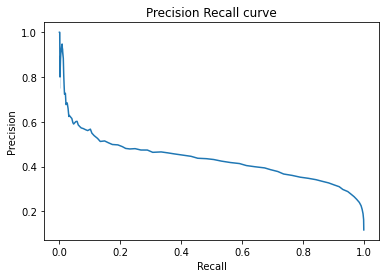

In [117]:
show_results(rfc,X_test,y_test)

Большие значения данной метрики конечно хороши, но не могут гарантировать хорошую работу модели при дисбалансе классов, так как модели просто достаточно говорить что все поступающие объекты 0 класса, следовательно она будет права в 99 случаях из 100.

F1 метрика показывает плохие результаты, модель плохо выделяет объекты положительного класса

Впринципе можно пойти по простому пути и просто уравнять классы в объеме, так как по 6к объектов каждого из классов более чем достаточно для обучения модели (при таком количестве признаков).

## Построим новую модель уже с сбалансированными классами

In [118]:
balanced_df = pd.concat([data[data.prediction==0][:data.prediction[data.prediction==1].count()],data[data.prediction==1]])

In [119]:
y = balanced_df.prediction.to_numpy()
X = balanced_df.drop(['prediction'],axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)

In [120]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

ROC-AUC SCORE:  0.9999665054195227
F1:  0.9962092494313874
Confusion matrix: 
 [[2022    3]
 [  12 1971]]


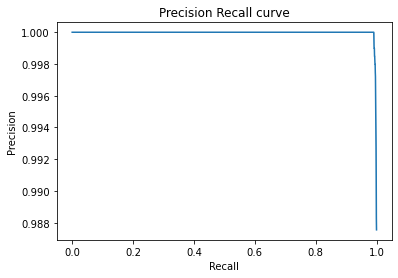

In [121]:
show_results(rfc,X_test,y_test)

Запустим модель для предсказания на неизвестных данных

In [124]:
result = rfc.predict(answer.to_numpy())
pd.DataFrame({"user_id":answer.user_id,"answer":np.int8(result)}).to_csv("Answer.csv",index=False)

In [126]:
result = rfc.predict_proba(answer.to_numpy())
pd.DataFrame({"user_id":answer.user_id,"answer":np.float16(result[:,1])}).to_csv("Answer_proba.csv",index=False)

Полученные цифры по прежнему выглядят нестандартно очень уж хороший результат, возможно когда производилась балансировка классов в объекты отрицательного класса попали те же люди что и в обучение.

## Проверим эту гипотезу

In [131]:
balanced_df = pd.concat([data[data.prediction==0][-data.prediction[data.prediction==1].count():],data[data.prediction==1]])
y = balanced_df.prediction.to_numpy()
X = balanced_df.drop(['prediction'],axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

ROC-AUC SCORE:  0.99999601551459
F1:  0.9987376925018935
Confusion matrix: 
 [[2025    0]
 [   5 1978]]


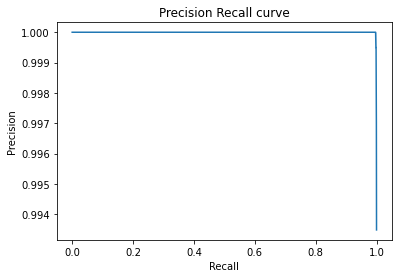

In [132]:
show_results(rfc,X_test,y_test)

Модель по прежнему хорошо работает, выглядит странно, но мне кажется что такое вполне может быть